# Sea Surface Temperature Bias - NOAA OISSTv2

This notebook plots the SST bias of a model simulation vs. climataology derived from NOAA OISSTv2

In [1]:
import os
import momlevel

In [2]:
config = {
    "id": "odiv-319",
    "pathPP": "/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/"
    + "om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/",
}

Dora will pass two environment variables to the script when running via the web engine:

* `DORA_ID`: The experiment ID in the database
* `DORA_PATHPP`: The top-level path to the post-processing experiment directory of the experiment

The block below will use values passed in by Dora but default to the values defined above in `config`. This is useful for interactive usage and debugging

In [3]:
for k, v in config.items():
    config[k] = (
        os.environ[f"DORA_{k.upper()}"]
        if f"DORA_{k.upper()}" in os.environ.keys()
        else v
    )

### Import Python Modules

In [4]:
import doralite
import glob
import momgrid
import subprocess

import xarray as xr

### Definie Local Parameters

In [5]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = 1993
end = 2017

### Determine What Files to Load

In [6]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_monthly"
static = f"{component}/{component}.static.nc"
varname = "tos"

chunk = "5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/ts/**/{chunk}/{component}.*.{varname}.nc", recursive=True))

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.tos.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.tos.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.tos.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200801-201212.tos.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.201301-201712.tos.nc


### DMgetting Files

Dora cannot issue calls to dmget

In [7]:
cmd = ["dmget"]+filelist+[staticfile]
_ = subprocess.check_output(cmd)

### Load model data and grid

In [8]:
# Model Data
ds = xr.open_mfdataset(filelist, use_cftime=True)
ds = ds.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))

In [9]:
# Grid Data
grid = momgrid.MOMgrid(staticfile)

In [10]:
# Combine model data with grid data
ds = grid.associate(ds)

In [11]:
ds

<xarray.Dataset>
Dimensions:     (time: 300, nv: 2, xh: 1440, yh: 1080)
Coordinates:
  * time        (time) object 1993-01-16 12:00:00 ... 2017-12-16 12:00:00
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.438e+03 1.44e+03
  * yh          (yh) float64 0.5 1.5 2.5 3.5 ... 1.078e+03 1.078e+03 1.08e+03
    geolon      (yh, xh) float32 -299.7 -299.5 -299.2 -299.0 ... 60.0 60.0 60.0
    geolat      (yh, xh) float32 -79.81 -79.81 -79.8 -79.8 ... 64.33 64.22 64.11
    areacello   (yh, xh) float32 3.439e+07 3.437e+07 ... 2.097e+06 9.053e+05
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) object dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) object dask.array<chunksize=(60,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 dask.array<chunksize=(60, 1080, 1440), meta=np.ndarray>
Attributes:
    title:               om5_b02_minthick1em3_MLErestart
    associated_files:    areacello: 19930101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

### Load observational data (if needed)

Note that Dora only mounts `/archive`, `/nbhome`, and `/home`

In [12]:
dsobs = xr.open_dataset("/archive/John.Krasting/NOAA_OISST_v2_annual_mean_1993-2017_OM4.nc", use_cftime=True)

### Perform some calculations

In [13]:
# Time-average the model data
model = momlevel.util.annual_average(ds.tos).mean("time").load()

# Obs data is already a climatology
obs = dsobs.tos

### Make a plot

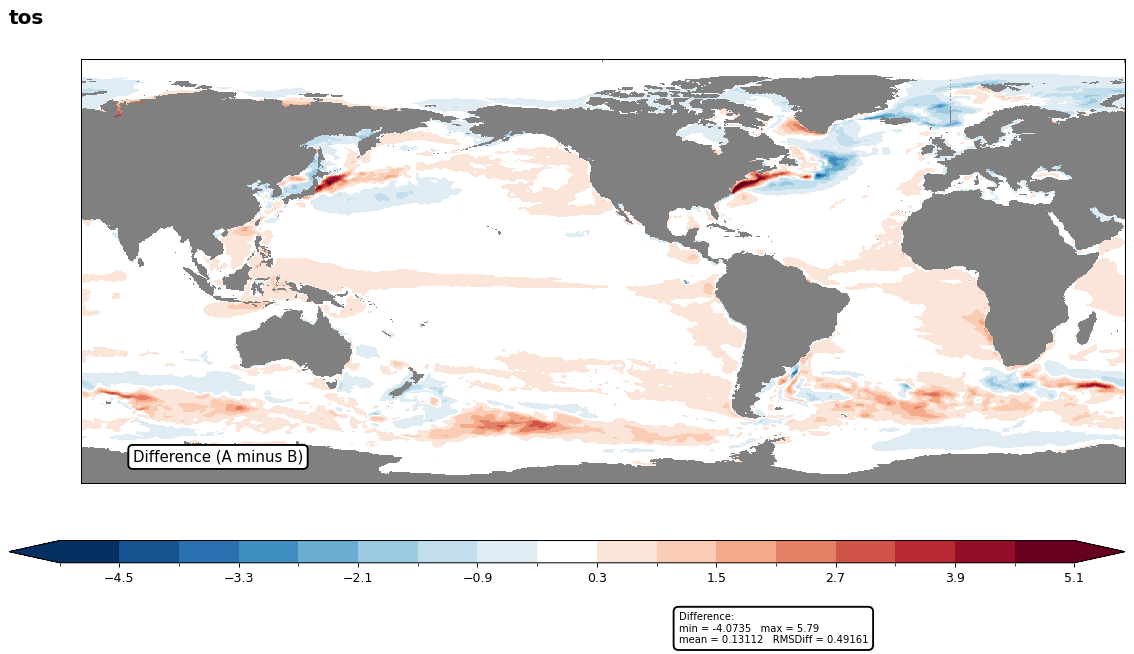

In [14]:
# momgrid will use a directory of pre-computed weights
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

_ = momgrid.compare(model, obs)